In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path

In [2]:
def unique(myList): return sorted(list(set(myList)))
def get_df_from_path(hdf5filePath):
    h = h5py.File(hdf5filePath, 'r+')
    history = h['history']
    colnames = history.attrs['column_names']
    assert len(history) == len(colnames)
    nbcols = len(colnames)
    _ = dict()
    for i, colname in zip(range(nbcols), colnames):
        _[colname] = history[i]
    return pd.DataFrame(_)

def get_info_from_path(hdf5filePath):
    #'HDF5Files/toyRates_logM-0.1_X0.6.hdf5' is a filepath, get logM and X from it
    logM = float(hdf5filePath.split('logM_')[1].split('_')[0])
    X = float(hdf5filePath.split('_X_')[1].split('_')[0])
    return logM, X

def get_µ_from_X(X): return 4 / ( 3 + 5*X )
def get_X_from_µ(µ): return ( 4 - 3*µ ) / ( 5*µ )
#benadering: M(H1) is niet helemaal 1, en dan nog isotopenbenadering en Z = A/2 ofzo enzo

class Track:    
    def __init__(self, hdf5filePath, H_cutoff = 0.999, Temp_reference = 10**3.0):
        self.path = hdf5filePath
        self.history = get_df_from_path(hdf5filePath)
        self.logM, self.X = get_info_from_path(hdf5filePath)
        self.M = 10**self.logM
        self.Mround = round(self.M, 3)
        self.µ = get_µ_from_X(self.X)
        self.ZAMS_L = None
        self.PMS_L = None
        self.ZAMS_index = self.compute_ZAMS_index(H_cutoff)
        self.PMS_index = self.compute_PMS_index(Temp_reference)

    def compute_ZAMS_index(self, H_cutoff=0.999):
        try:
            index = np.where(self.history.X_center < H_cutoff * self.history.X_center[0])[0][0]
        except:
            return None
        self.ZAMS_index = index
        self.ZAMS_index_calculated = True
        self.ZAMS_L = self.history.L_surf[self.ZAMS_index]
        return index

    def compute_PMS_index(self, Temp_reference = 10**3.0):
        if self.X != 0 and self.ZAMS_index == None:
            return None
        try:
            index = np.argmin(self.history.T_surf[0:self.ZAMS_index] - Temp_reference)
            self.PMS_index = index
            self.PMS_L = self.history.L_surf[self.PMS_index]
        except:
            return None
        return index
    
    def compute_indices(self, H_cutoff=0.999999, Temp_reference = 10**3.0):
        self.compute_ZAMS_index(H_cutoff)
        self.compute_PMS_index(Temp_reference)
    
    def get_gridpoint(self):
        return (self.logM, self.X)
    
    def plot_HRD_PMS(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_title('HRD')
        ax.set_xlabel('log(Teff)')
        ax.set_ylabel('log(L)')
        ax.plot(np.log10(self.history.T_surf), np.log10(self.history.L_surf), label=self.path)
        ax.invert_xaxis()
        return ax
import time
class Grid:
    def __init__(self, tracks):
        self.tracks = tracks
        self.gridpoints = [track.get_gridpoint() for track in tracks]

        print('Grid with', len(self.tracks), 'tracks', end="\r")
        #time.sleep(0.05)
        self.logMs = np.array([track.logM for track in tracks])
        self.Ms = np.array([track.M for track in tracks])
        self.Xs = np.array([track.X for track in tracks])
        self.µs = np.array([track.µ for track in tracks])
        self.ZAMS_Ls = np.array([track.ZAMS_L for track in tracks])
        self.PMS_Ls = np.array([track.PMS_L for track in tracks])
        self.failed_tracks = [track for track in tracks if track.ZAMS_index == None]
        #nb of logMs:
        self.nb_logMs = len(set(self.logMs))
    def get_info(self):
        print('Grid with', len(self.tracks), 'tracks')
        print('logMs:', self.logMs)
        print('Xs:', self.Xs)
        print('µs:', self.µs)
    def generate_cut_grid(self, logM_lo, logM_hi, X_lo, X_hi):
        return Grid([track for track in self.tracks if logM_lo <= track.logM <= logM_hi and X_lo <= track.X <= X_hi])
    def generate_cut_grid_µ(self, µ_lo, µ_hi):
        return Grid([track for track in self.tracks if µ_lo <= track.µ <= µ_hi])
    def generate_custom_grid(self, logMs, Xs):
        return Grid([track for track in self.tracks if np.round(track.logM,3) in logMs and np.round(track.X,3) in Xs])
    def collapse_grid_logM(self, logM):
        return Grid([track for track in self.tracks if track.logM == logM])
    def collapse_grid_X(self, X):
        return Grid([track for track in self.tracks if track.X == X])
    
    def colors_and_shapes(self):
        colors = plt.cm.gist_earth(np.linspace(0, 1, self.nb_logMs))
        colors = {np.round(logM,3):color for logM, color in zip(unique(self.logMs), colors)}
        shapes = ['o','s','*','X','D']
        shapes = {np.round(logM,3) : shapes[i%len(shapes)] for i, logM in enumerate(sorted(list(set(self.logMs))))}
        return colors, shapes
    def HRD_things(self, ax = None):
        colors, shapes = self.colors_and_shapes()
        if ax == None:
            fig, ax = plt.subplots()
        ax.set_xlabel('$ \log(T_{eff} / K) $')
        ax.set_ylabel('$ \log(L / L_{\odot}) $')
        ax.invert_xaxis()
        return ax, colors, shapes
    
    def plot_HRD(self, ax = None):
        ax, colors, shapes = self.HRD_things(ax)
        for track in self.tracks:
            ax.plot(np.log10(track.history.T_surf), np.log10(track.history.L_surf), label=track.get_gridpoint(), color = colors[track.logM])
            if track.ZAMS_index != None:
                ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]),color = colors[track.logM])
        return ax
    
    def plot_HRD(self, ax = None):
        track_logM_1 = Track("../../DualRuns/DualGrid3/logM_1.0_X_0.7154_.history.hdf5")
        ax, colors, shapes = self.HRD_things(ax)
        for track in self.tracks:
            #if track.ZAMS_index == None:
            #    print('No ZAMS for', track.get_gridpoint())
            #    continue
            if track.logM == 1.0:
                logT = np.log10(track.history.T_surf)
                logL = np.log10(track_logM_1.history.L_surf)
                ax.plot(logT, logL, color = colors[track.logM])
                ax.text(logT[1767]+0.15, logL[1767], f"$log M = {track.logM}$", fontsize=8)
                print('Plotted', track.get_gridpoint())
                continue

            try:
                logT = np.log10(track.history.T_surf)
                logL = np.log10(track.history.L_surf)
                ax.plot(logT[track.ZAMS_index:-1], logL[track.ZAMS_index:-1], color = colors[track.logM])
                ax.plot(logT[0:track.ZAMS_index], logL[0:track.ZAMS_index], color = colors[track.logM],alpha=0.3)
                ax.scatter(logT[track.ZAMS_index], logL[track.ZAMS_index], color = colors[track.logM])
                ax.set_xlim(4.6,3.6)
                if track.logM % 0.25==0:
                    ax.text(logT[track.ZAMS_index]+0.2, logL[track.ZAMS_index], f"$log M = {track.logM}$", fontsize=8)
            except:
                print('Plotting failed for, try again', track.get_gridpoint())
                try:
                    logT = np.log10(track.history.T_surf)
                    logL = np.log10(track.history.L_surf)
                    print("bla")
                    #ax.plot(logT[track.ZAMS_index:-1], logL[track.ZAMS_index:-1], color = colors[track.logM])
                    ax.plot(logT, logL, color = colors[track.logM],alpha=0.3)
                    ax.set_xlim(4.6,3.6)
                    if track.logM % 0.25==0:
                        ax.text(logT[-1]+0.2, logL[-1], f"$log M = {track.logM}$", fontsize=8)
                except:
                    print('Plotting failed again for', track.get_gridpoint())
        return ax

    
    def plot_HRD_PMS(self, ax=None):
        ax, colors, shapes = self.HRD_things(ax)   
        if ax == None: fig, ax = plt.subplots()
        for index, track in enumerate(self.tracks):
            if track.ZAMS_index == None:
                continue
            ax.plot(np.log10(track.history.T_surf[0:track.ZAMS_index]), np.log10(track.history.L_surf[0:track.ZAMS_index]), color = colors[track.logM])
            #scatter zams
            ax.scatter(np.log10(track.history.T_surf[track.ZAMS_index]), np.log10(track.history.L_surf[track.ZAMS_index]), color = colors[track.logM], marker = shapes[track.logM])
        return ax
    
    def plot_grid(self, ax = None ):
        colors, shapes = self.colors_and_shapes() 
        if ax == None: fig, ax = plt.subplots()
        ax.set_title('Grid')
        ax.set_xlabel('Mass $\log(M/M_{\odot})$')
        ax.set_ylabel('Hydrogen fraction X')
        for track in self.tracks:
            marker = 'x' if track.PMS_L == None else 'o'       
            ax.scatter(track.logM, track.X, color = colors[track.logM], marker = marker)
        secax = ax.secondary_yaxis('right', functions=(get_µ_from_X, get_X_from_µ))
        secax.set_ylabel('Mean molecular weight $\mu$', rotation=270, labelpad=15)

In [3]:
p = Path('../../DualRuns/DualGrid3')
_ = list(p.glob('*history.hdf5'))
paths = [str(hdf5file) for hdf5file in _]
tracks = [Track(path) for path in paths]
totalGrid = Grid(tracks)

Plotting failed for, try again (0.9, 0.7154)
bla
Plotting failed for, try again (1.4, 0.7154)
bla
Plotting failed for, try again (1.1, 0.7154)
bla
Plotting failed for, try again (1.5, 0.7154)
bla
Plotting failed again for (1.5, 0.7154)
Plotting failed for, try again (1.2, 0.7154)
bla
Plotting failed for, try again (1.3, 0.7154)
bla
Plotted (1.0, 0.7154)


(4.65, 3.0)

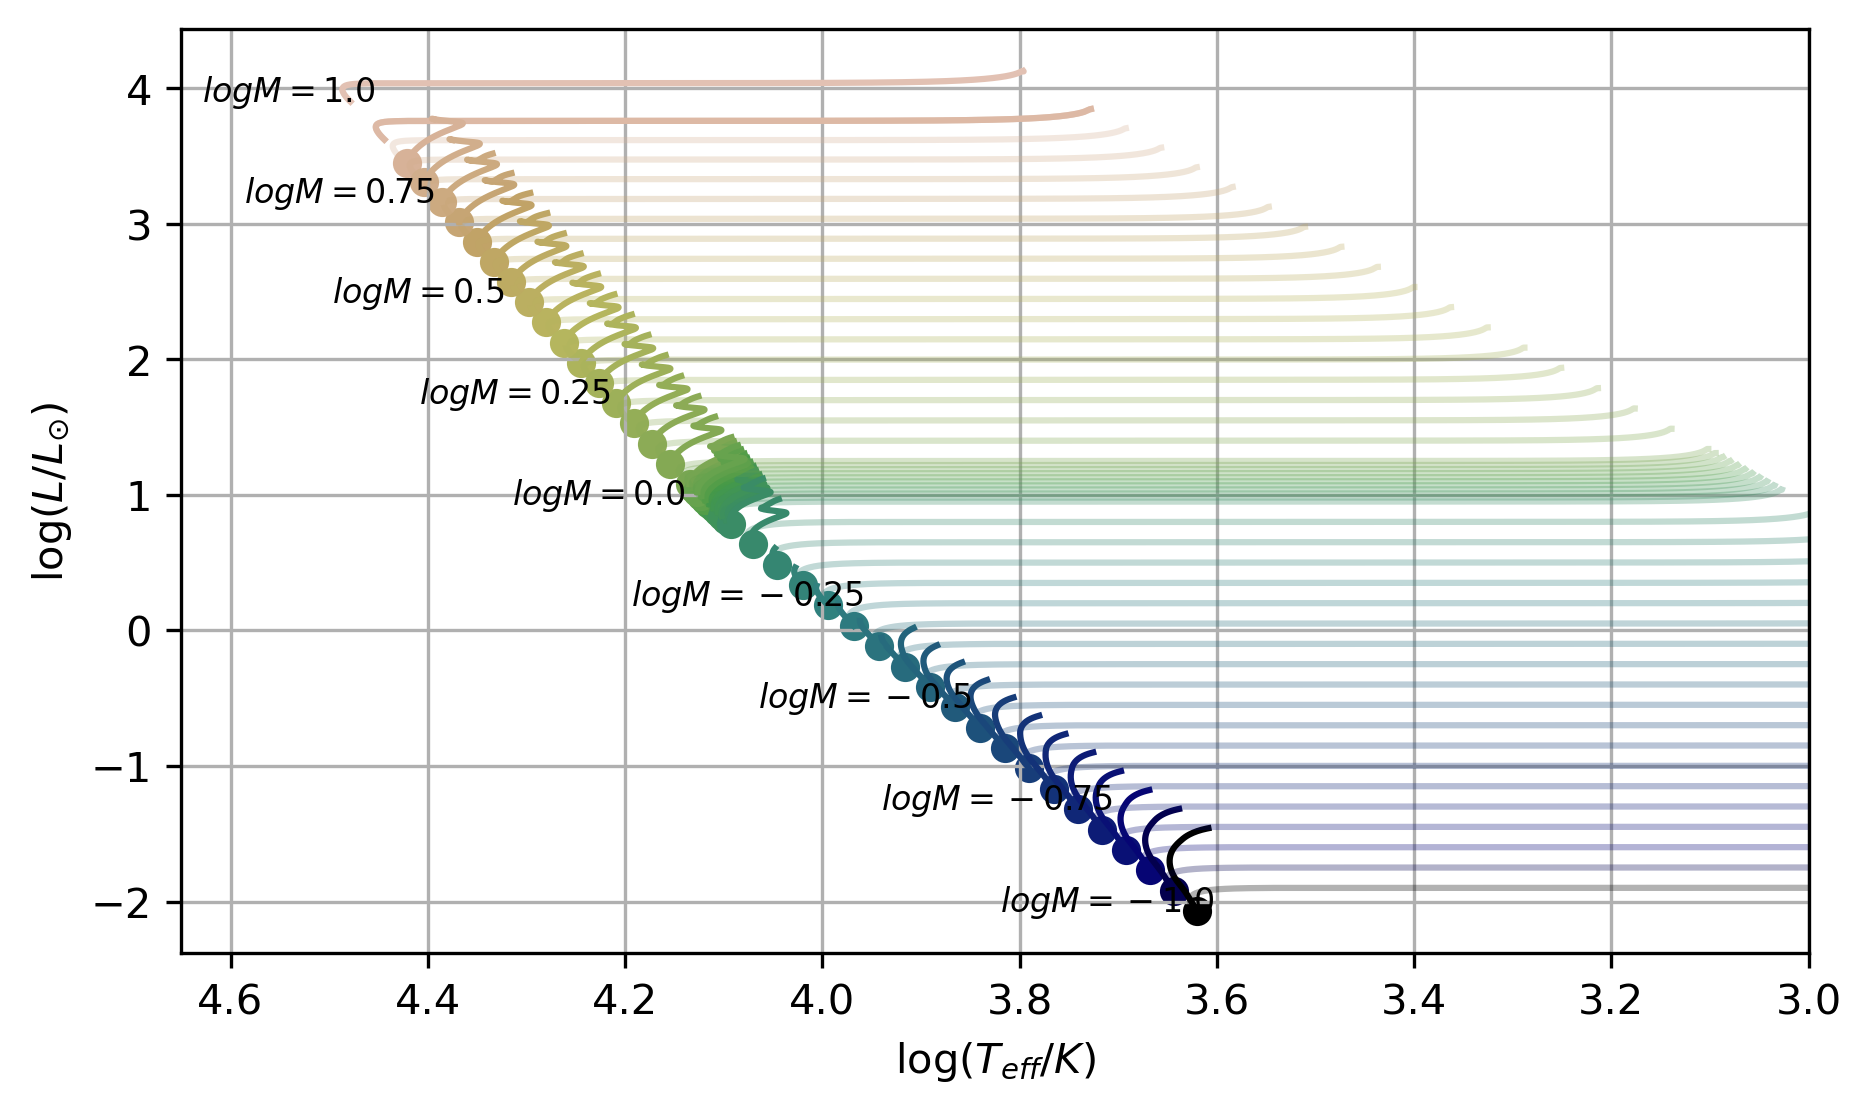

In [8]:
fig, ax = plt.subplots(1,1,figsize=(7,4),dpi=300)
totalGrid.plot_HRD(ax)
ax.grid()
ax.set_xlim(4.65,3)



In [6]:
totalGrid.tracks[0].logM

0.25

In [7]:
float(bla.split('_X_')[1].split('_')[0])

NameError: name 'bla' is not defined

In [ ]:
bla

'../../DualRuns/DualGrid3/logM_0.9_X_0.7154_.profiles.hdf5'

In [ ]:
float(bla.split('logM_')[1].split('_')[0])

0.9